## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2006,
 3: 8024,
 4: 32096,
 5: 128384,
 6: 513536,
 7: 2054144,
 8: 8216576,
 9: 32866304}

Running 12760 CDFs


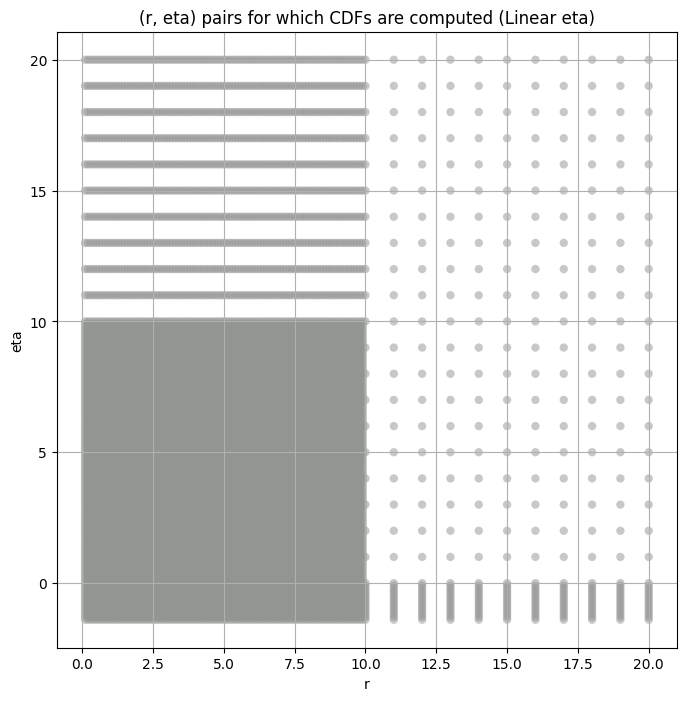

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                
2      1056.889000  930.928500  1189.896000   2.568110    1.749090   
3       231.587700  215.850390   247.845180   3.800917    3.201513   
4        48.523850   45.008670    52.177510   6.300665    5.255464   
5         9.365974    8.577611    10.193540   9.227902    7.612481   
6         1.842475    1.669544     2.028080  12.415792    9.957208   
7         0.408683    0.368238     0.452737  14.210211   10.879326   
8         0.140603    0.127459     0.154797  12.104240    9.034415   
9         0.072376    0.066349     0.079045   9.536445    6.531637   

       kurt_upper  total_samples  
layer                             
2        3.483325         2006.0  
3        4.483109         8024.0  
4        7.579384        32096.0  
5       12.297548       128384.0  
6       16.035275       513536.0  
7       19.988205      2054144.0  
8       17.255356      8216576.0  
9       16.300930     32866304.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1056.889000    1056.889038      785.728882      640.595459   
3       231.587700     231.587708      204.831924      187.942368   
4        48.523850      48.523849       45.826000       44.008091   
5         9.365974       9.365974        9.096838        8.912044   
6         1.842475       1.842475        1.774931        1.729651   
7         0.408683       0.408682        0.391318        0.380140   
8         0.140603       0.140603        0.134958        0.131312   
9         0.072376       0.072376        0.069635        0.067967   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          541.166809       465.224121       352.938385       273.058990   
3          174.298508       162.779160       143.629868       128.171585   
4           42.516766        41.190792        38.905563        36.921574   
5            8.749342         8.600798         8.334800         8.098783   
6            1.691415         1.657202         1.596844         1.543826   
7            0.370810         0.362563         0.348243         0.335831   
8            0.128276         0.125603         0.120972         0.116990   
9            0.066590         0.065387         0.063325         0.061573   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           213.121475       167.378616       132.350723        61.502502  
3           115.389618       104.367828        94.916245        72.773956  
4            35.198284        33.651394        32.239799        28.682737  
5             7.884279         7.687543         7.504758         7.021797  
6             1.495914         1.452217         1.411929         1.306198  
7             0.324761         0.314734         0.305545         0.281777  
8             0.113463         0.110286         0.107388         0.099936  
9             0.060037         0.058664         0.057418         0.054244

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.013333140957542455 1056.889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.021838848204604244 785.7289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.03733131301054149 640.59546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.049611725828652586 541.1668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0607442046325376 465.22412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.08129819009028105 352.9384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.10147987941031256 273.059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.12190695531028395 213.12148


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1440653328503826 167.37862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.16797761768942485 132.35072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.22873866879063381 61.502502
Number of samples: 2006, Without approximation : 2006.0


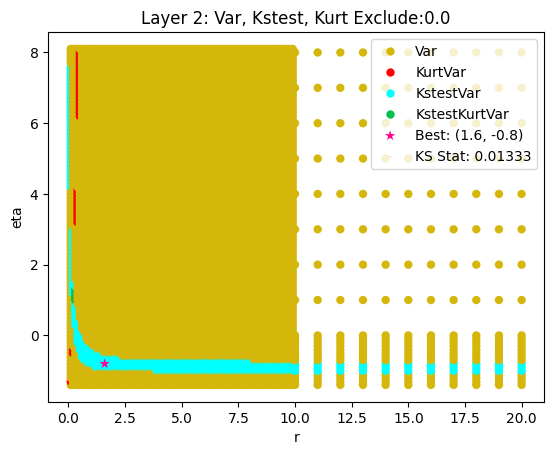

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.01284925191448627 231.5877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.012824743281822593 204.83192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.017205529439806577 187.94237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.019833072799584017 174.29851


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.020056302538791204 162.77916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.024500742018176896 143.62987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03115894193702331 128.17159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03782513929973075 115.38962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.04409413589802235 104.36783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.05031500218142963 94.916245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.06875370833353044 72.77396
Number of samples: 8024, Without approximation : 8024.0


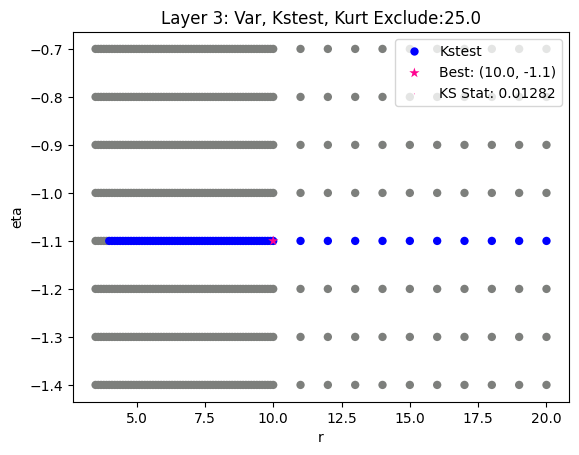

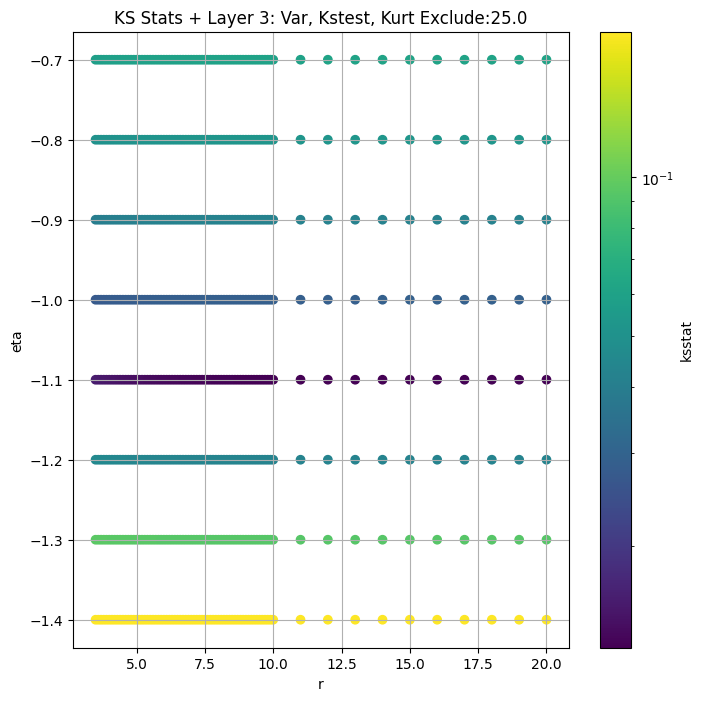

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.02046984047856426 48.52385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.02046984047856426 45.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.02046984047856426 44.00809


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.02046984047856426 42.516766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.02046984047856426 41.190792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.02046984047856426 38.905563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.020469840478564205 36.921574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.020469840478564205 35.198284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.020469840478564205 33.651394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.020469840478564205 32.2398


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.023242603798361516 28.682737
Number of samples: 32096, Without approximation : 32096.0


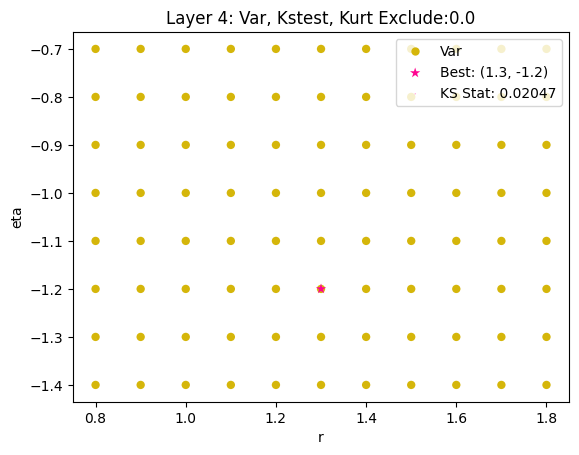

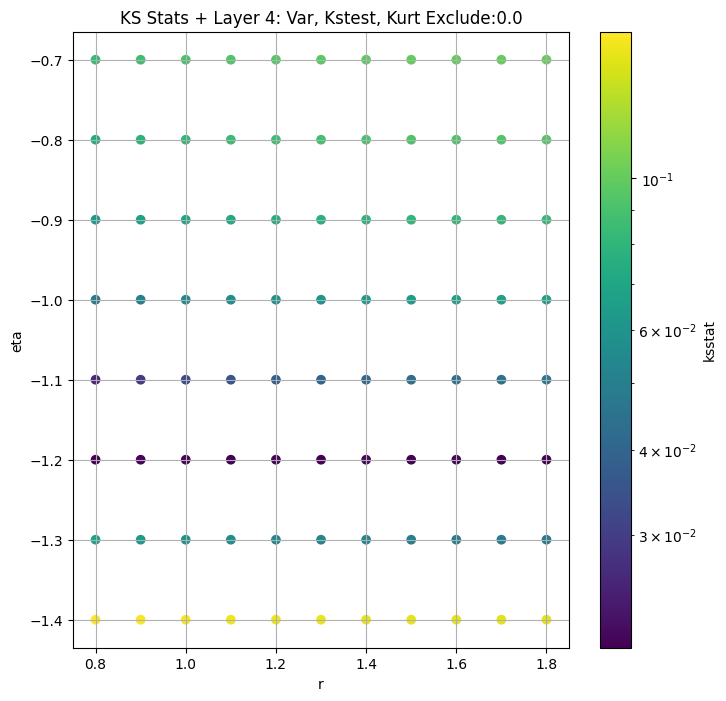

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.04454999999999981 9.365974


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.04454999999999981 9.096838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.04454999999999981 8.912044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.04454999999999981 8.749342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.04454999999999981 8.600798


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.04454999999999981 8.3348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.04454999999999981 8.098783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.04454999999999981 7.884279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04454999999999981 7.687543


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04454999999999981 7.5047584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04454999999999981 7.021797
Number of samples: 100000, Without approximation : 128384.0


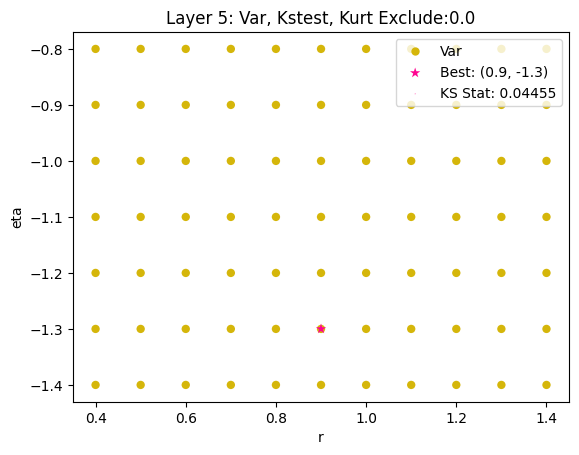

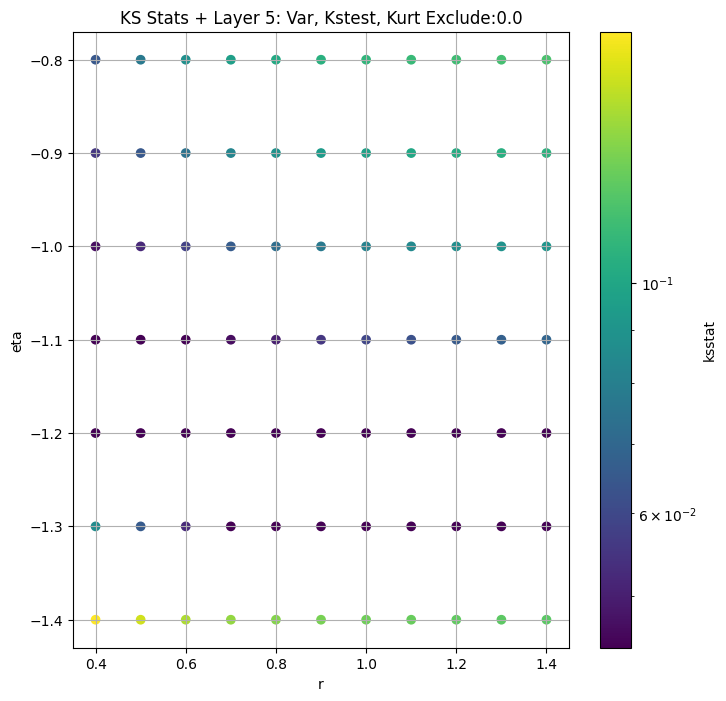

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.08459999999999979 1.842475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.08459999999999979 1.774931


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.08459999999999979 1.7296506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.08459999999999979 1.6914146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.08459999999999979 1.6572016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.08459999999999979 1.5968438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.08459999999999979 1.5438261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.08459999999999979 1.4959141


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.08459999999999979 1.4522169


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.08459999999999979 1.4119287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.08459999999999979 1.3061976
Number of samples: 100000, Without approximation : 513536.0


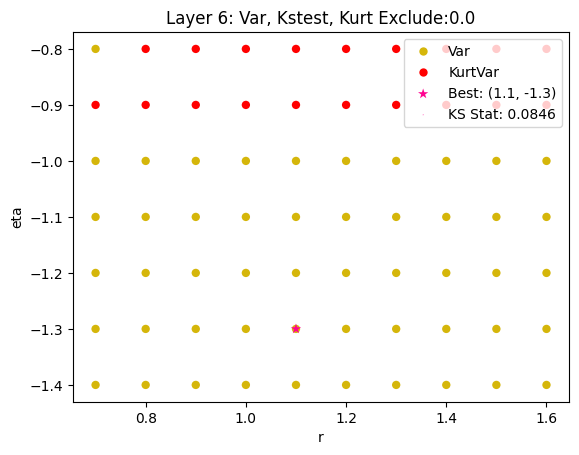

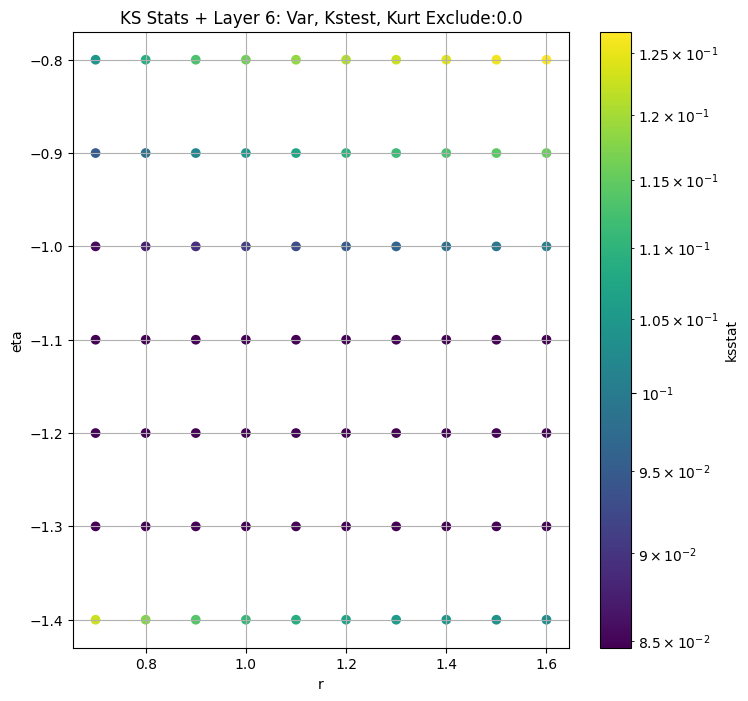

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.1302299999999998 0.4086825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.1302299999999998 0.3913177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.1302299999999998 0.38013968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.1302299999999998 0.37081045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.1302299999999998 0.36256346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.1302299999999998 0.34824258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.1302299999999998 0.33583102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.1302299999999998 0.32476118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.1302299999999998 0.31473422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.1302299999999998 0.3055452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.1302299999999998 0.2817766
Number of samples: 100000, Without approximation : 2054144.0


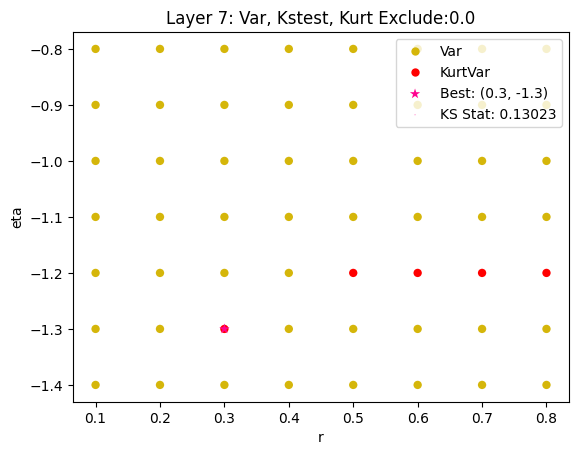

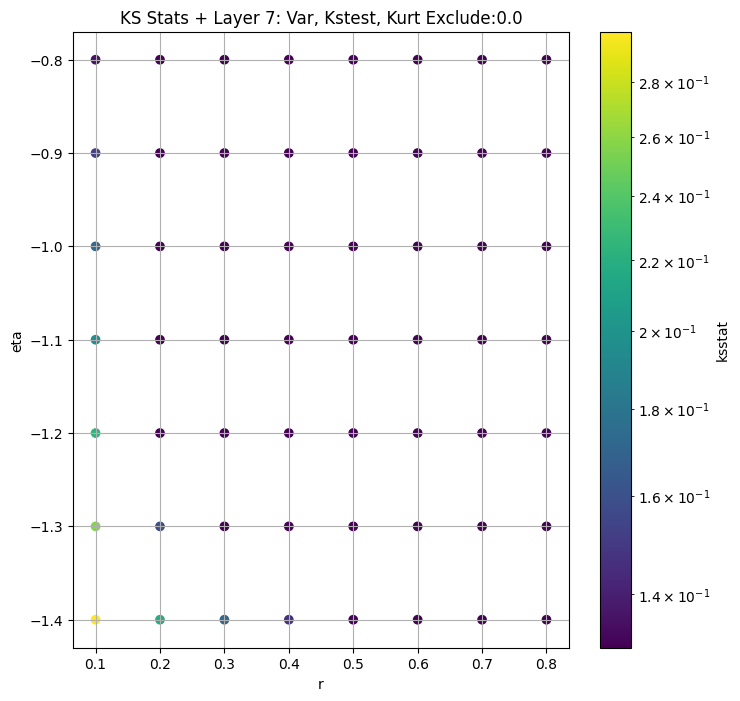

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.17649999999999977 0.14060296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.17649999999999977 0.13495845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.17649999999999977 0.13131204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.17649999999999977 0.12827556


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.17649999999999977 0.1256035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.17649999999999977 0.120971665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.17649999999999977 0.11699028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.17649999999999977 0.11346337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.17649999999999977 0.11028595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.17649999999999977 0.107387856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.17649999999999977 0.099936314
Number of samples: 100000, Without approximation : 8216576.0


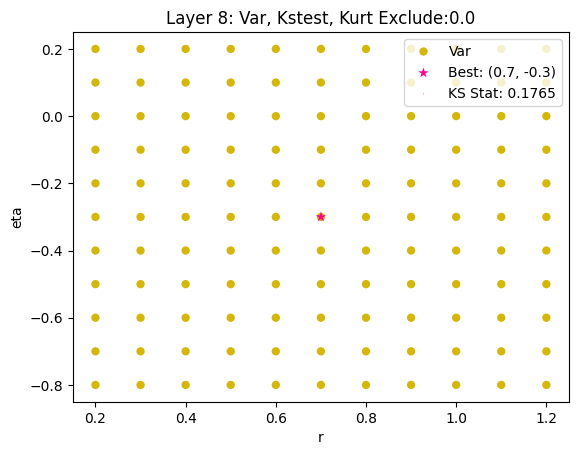

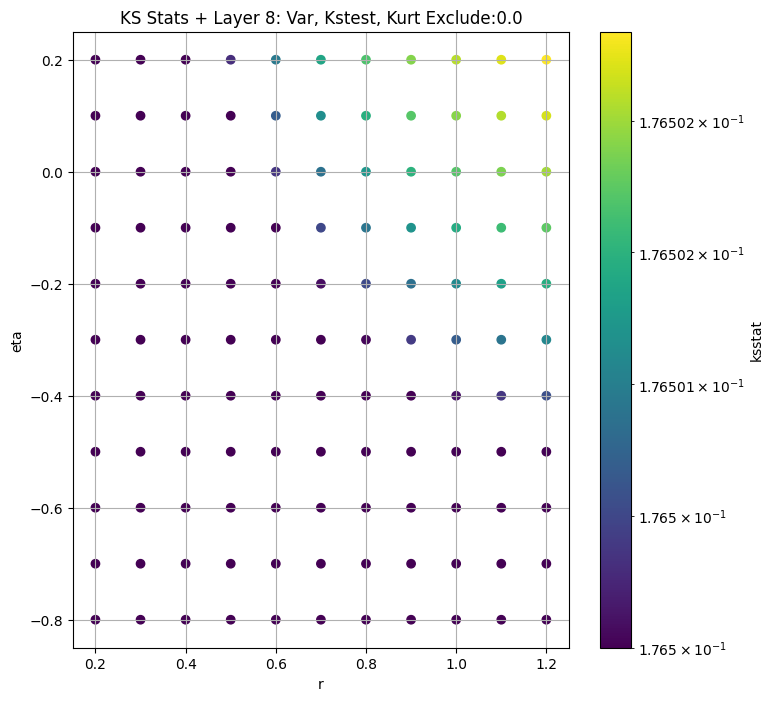

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.22306000000000004 0.072375886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.22306000000000004 0.0696346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.22306000000000004 0.06796702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.22306000000000004 0.0665899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.22306000000000004 0.065387435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.22306000000000004 0.0633246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.22306000000000004 0.061572794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.22306000000000004 0.060037483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.22306000000000004 0.058664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.22306000000000004 0.057418235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.22306000000000004 0.05424439
Number of samples: 100000, Without approximation : 32866304.0


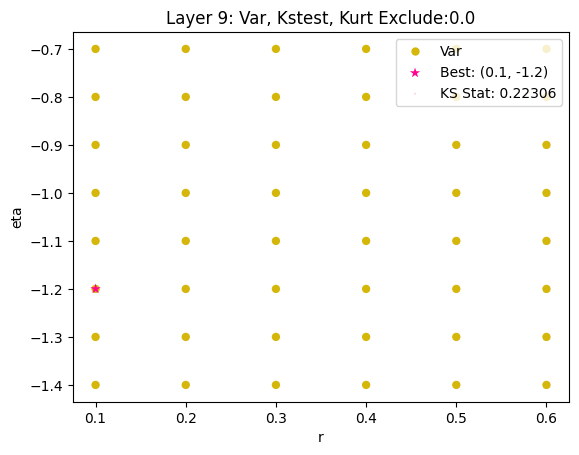

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                
2      1056.889000  930.928500  1189.896000   2.568110    1.749090   
3       231.587700  215.850390   247.845180   3.800917    3.201513   
4        48.523850   45.008670    52.177510   6.300665    5.255464   
5         9.365974    8.577611    10.193540   9.227902    7.612481   
6         1.842475    1.669544     2.028080  12.415792    9.957208   
7         0.408683    0.368238     0.452737  14.210211   10.879326   
8         0.140603    0.127459     0.154797  12.104240    9.034415   
9         0.072376    0.066349     0.079045   9.536445    6.531637   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.483325         2006.0             0.013333        1.6         -0.8   
3        4.483109         8024.0             0.012825       10.0         -1.1   
4        7.579384        32096.0             0.020470        1.3         -1.2   
5       12.297548       128384.0             0.044550        0.9         -1.3   
6       16.035275       513536.0             0.084600        1.1         -1.3   
7       19.988205      2054144.0             0.130230        0.3         -1.3   
8       17.255356      8216576.0             0.176500        0.7         -0.3   
9       16.300930     32866304.0             0.223060        0.1         -1.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.211703e+03                     0.0         1056.889000   
3       7.490835e+02                    25.0          204.831920   
4       1.914674e+02                     0.0           48.523850   
5       4.307167e+01                     0.0            9.365974   
6       9.795379e+00                     0.0            1.842475   
7       9.223405e-02                     0.0            0.408683   
8       5.593899e-02                     0.0            0.140603   
9       3.021948e-10                     0.0            0.072376   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.030238  
3                     0.015140  
4                     0.007575  
5                     0.003789  
6                     0.001895  
7                     0.000947  
8                     0.000474  
9                     0.000237

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.06268238412111227, var: 465.22412109375


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.05184901059129421, var: 541.1668090820312


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.03932754792731796, var: 640.595458984375


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.024199326918373787, var: 785.7288818359375


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.013273621264486668, var: 1056.8890380859375
Number of samples: 2006, Without approximation : 2006.0


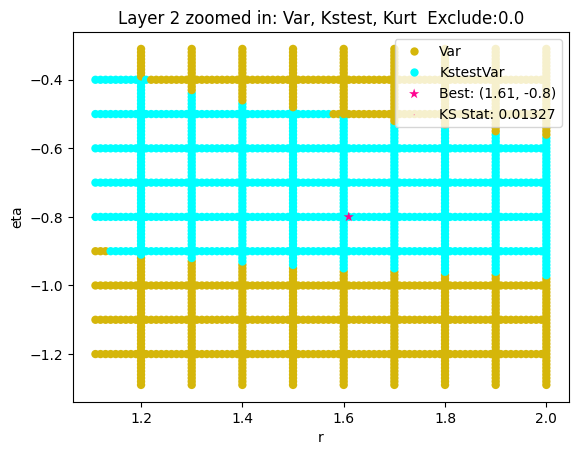

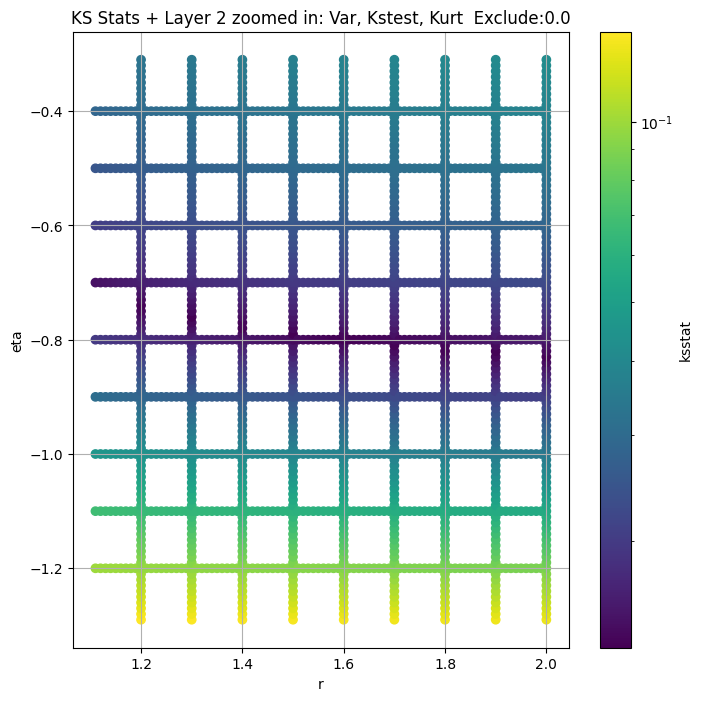

Layer 3


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + 100 = 125, ksstat: 0.021848826387290132, var: 152.7515106201172


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + 75 = 100, ksstat: 0.02301142900960418, var: 162.77915954589844


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + 50 = 75, ksstat: 0.021839413588769174, var: 174.2985076904297


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + 25 = 50, ksstat: 0.017580627671044513, var: 187.94236755371094


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + 0 = 25, ksstat: 0.012824743281822593, var: 204.83192443847656


  0%|          | 0/40 [00:00<?, ?it/s]

Finding Minimum after computing 40 CDFs
layer 3, 25.0 + -25 = 0, ksstat: 0.015014535686391883, var: 231.58770751953125
Number of samples: 8024, Without approximation : 8024.0


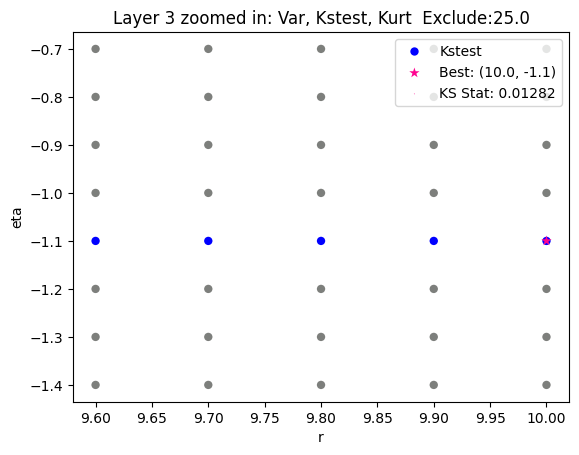

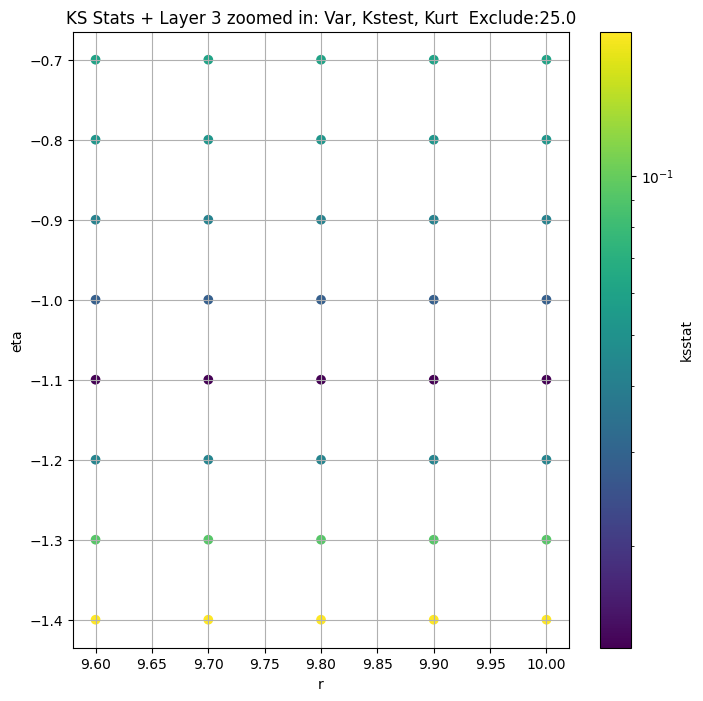

Layer 4


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.020469840478564205, var: 41.190792083740234


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.020469840478564205, var: 42.51676559448242


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.02046984047856415, var: 44.00809097290039


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.02046984047856415, var: 45.82600021362305


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.02046984047856415, var: 48.52384948730469
Number of samples: 32096, Without approximation : 32096.0


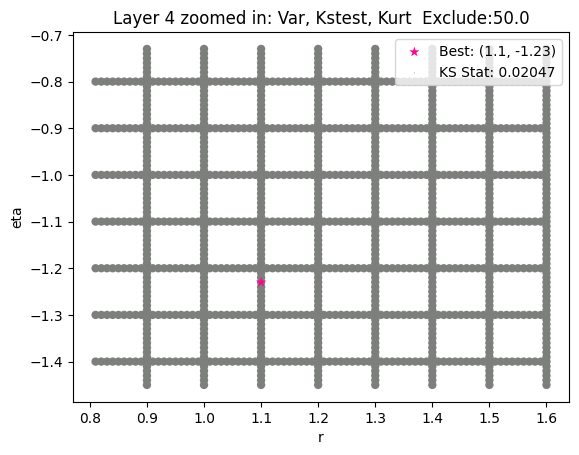

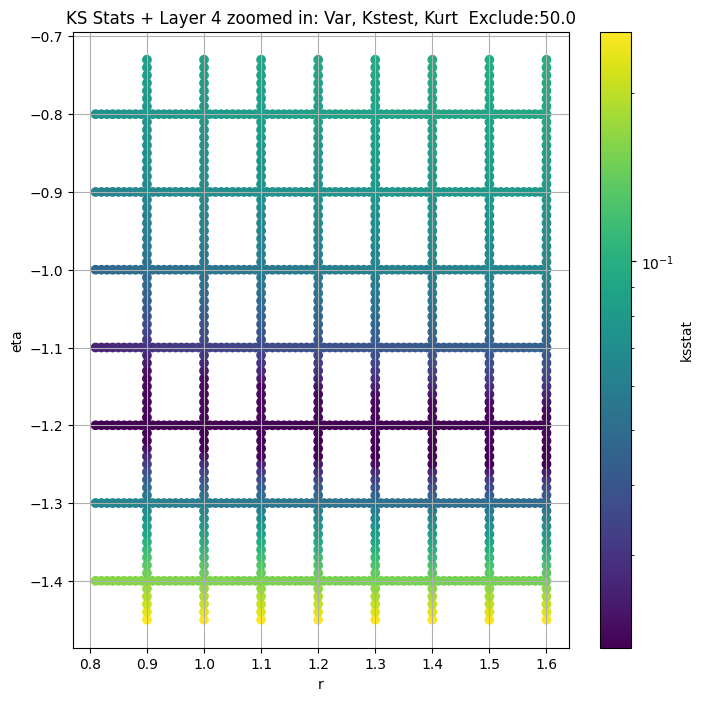

Layer 5


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.044549999999999756, var: 8.600797653198242


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.044549999999999756, var: 8.74934196472168


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.044549999999999756, var: 8.912043571472168


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.044549999999999756, var: 9.096837997436523


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.044549999999999756, var: 9.365974426269531
Number of samples: 100000, Without approximation : 128384.0


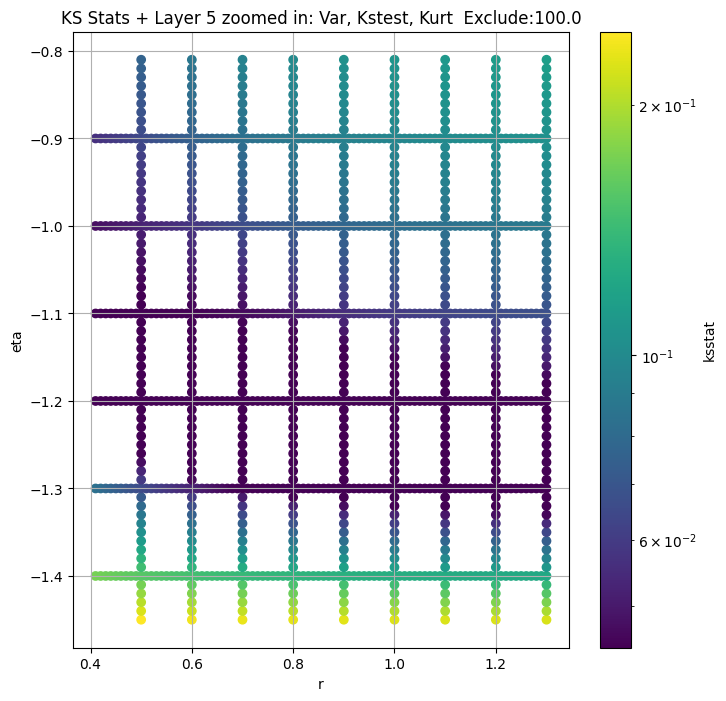

Layer 6


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.08459999999999979, var: 1.6572016477584839


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.08459999999999979, var: 1.6914145946502686


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.08459999999999979, var: 1.729650616645813


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.08459999999999979, var: 1.7749309539794922


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.08459999999999979, var: 1.8424750566482544
Number of samples: 100000, Without approximation : 513536.0


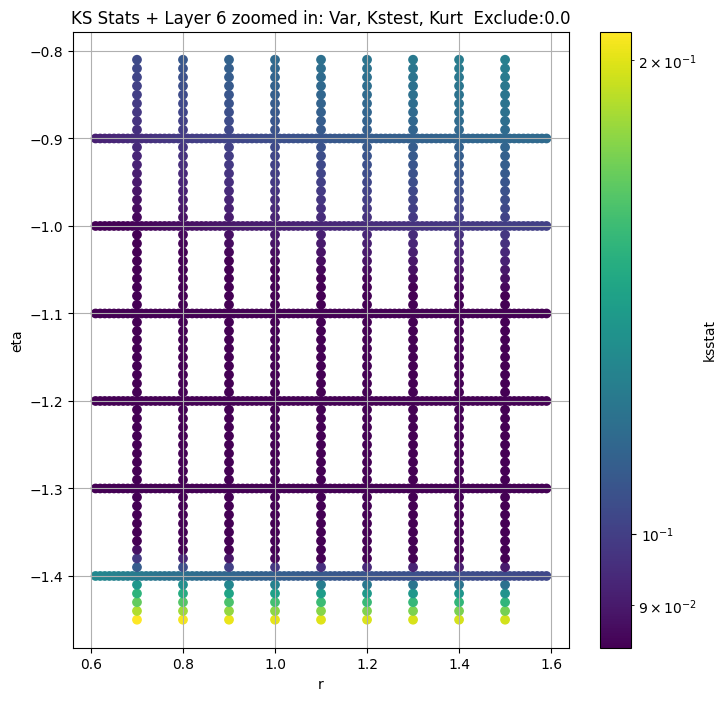

Layer 7


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.1302299999999998, var: 0.36256346106529236


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.1302299999999998, var: 0.37081044912338257


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.1302299999999998, var: 0.38013967871665955


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.1302299999999998, var: 0.3913176953792572


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.1302299999999998, var: 0.4086824953556061
Number of samples: 100000, Without approximation : 2054144.0


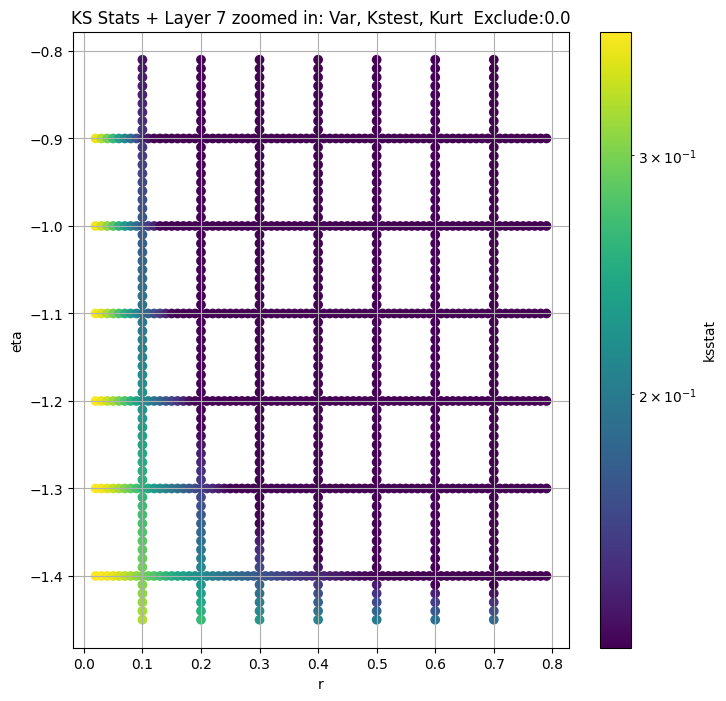

Layer 8


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.17649999999999977, var: 0.12560349702835083


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.17649999999999977, var: 0.1282755583524704


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.17649999999999977, var: 0.1313120424747467


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.17649999999999977, var: 0.1349584460258484


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.17649999999999977, var: 0.1406029611825943
Number of samples: 100000, Without approximation : 8216576.0


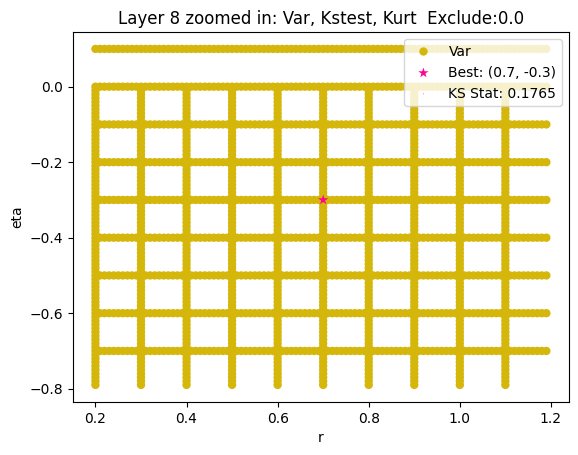

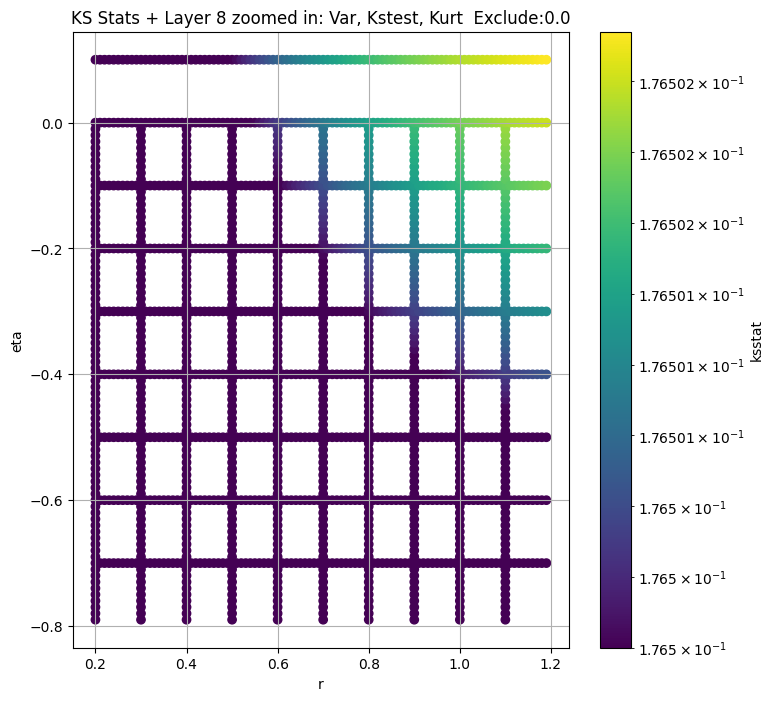

Layer 9


  0%|          | 0/746 [00:00<?, ?it/s]

Finding Minimum after computing 746 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.22306000000000004, var: 0.06538743525743484


  0%|          | 0/746 [00:00<?, ?it/s]

Finding Minimum after computing 746 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.22306000000000004, var: 0.06658989936113358


  0%|          | 0/746 [00:00<?, ?it/s]

Finding Minimum after computing 746 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.22306000000000004, var: 0.0679670199751854


  0%|          | 0/746 [00:00<?, ?it/s]

Finding Minimum after computing 746 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.22306000000000004, var: 0.06963460147380829


  0%|          | 0/746 [00:00<?, ?it/s]

Finding Minimum after computing 746 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.22306000000000004, var: 0.07237588614225388
Number of samples: 100000, Without approximation : 32866304.0


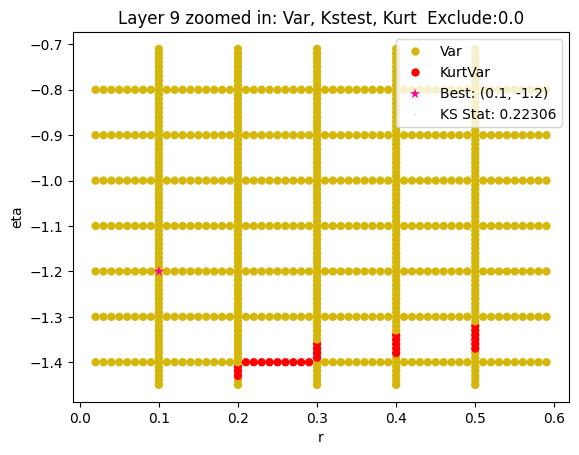

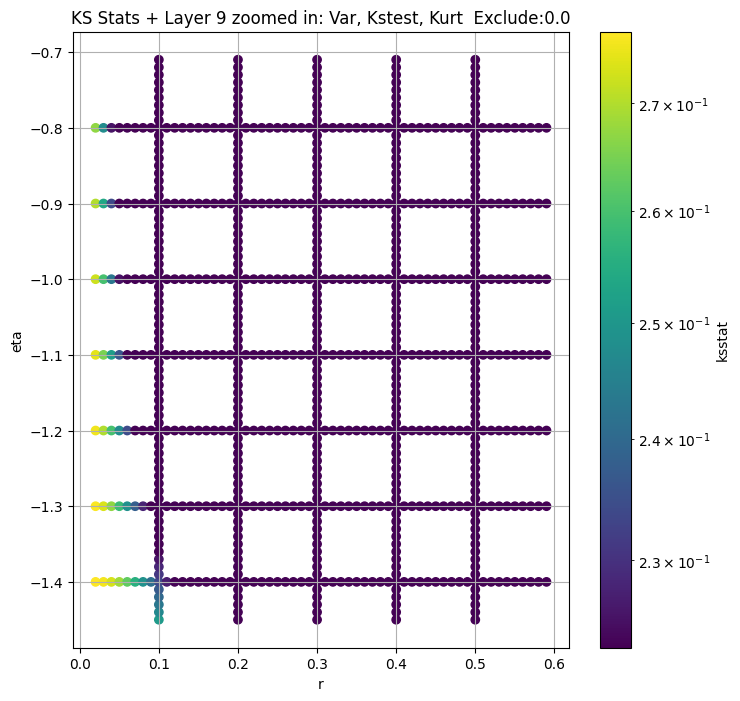

Not a fit


obs_var   var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                
2      1056.889000  930.928500  1189.896000   2.568110    1.749090   
3       231.587700  215.850390   247.845180   3.800917    3.201513   
4        48.523850   45.008670    52.177510   6.300665    5.255464   
5         9.365974    8.577611    10.193540   9.227902    7.612481   
6         1.842475    1.669544     2.028080  12.415792    9.957208   
7         0.408683    0.368238     0.452737  14.210211   10.879326   
8         0.140603    0.127459     0.154797  12.104240    9.034415   
9         0.072376    0.066349     0.079045   9.536445    6.531637   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.483325         2006.0             0.013333        1.6         -0.8   
3        4.483109         8024.0             0.012825       10.0         -1.1   
4        7.579384        32096.0             0.020470        1.3         -1.2   
5       12.297548       128384.0             0.044550        0.9         -1.3   
6       16.035275       513536.0             0.084600        1.1         -1.3   
7       19.988205      2054144.0             0.130230        0.3         -1.3   
8       17.255356      8216576.0             0.176500        0.7         -0.3   
9       16.300930     32866304.0             0.223060        0.1         -1.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.211703e+03                     0.0         1056.889038   
3       7.490835e+02                    25.0          204.831920   
4       1.914674e+02                     0.0           44.008091   
5       4.307167e+01                     0.0            8.600798   
6       9.795379e+00                     0.0            1.842475   
7       9.223405e-02                     0.0            0.408683   
8       5.593899e-02                     0.0            0.140603   
9       3.021948e-10                     0.0            0.072376   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.030238          0.013274    1.61     -0.80   
3                     0.015140          0.012825   10.00     -1.10   
4                     0.007575          0.020470    1.10     -1.23   
5                     0.003789          0.044550    0.80     -1.26   
6                     0.001895          0.084600    1.10     -1.30   
7                     0.000947          0.130230    0.30     -1.30   
8                     0.000474          0.176500    0.70     -0.30   
9                     0.000237          0.223060    0.10     -1.20   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.218582e+03                  0.0        10153  
3      7.490835e+02                 25.0        11424  
4      1.746343e+02                 50.0         4513  
5      2.894678e+01                100.0          949  
6      9.795379e+00                  0.0          250  
7      9.223405e-02                  0.0          103  
8      5.593899e-02                  0.0           57  
9      3.021948e-10                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

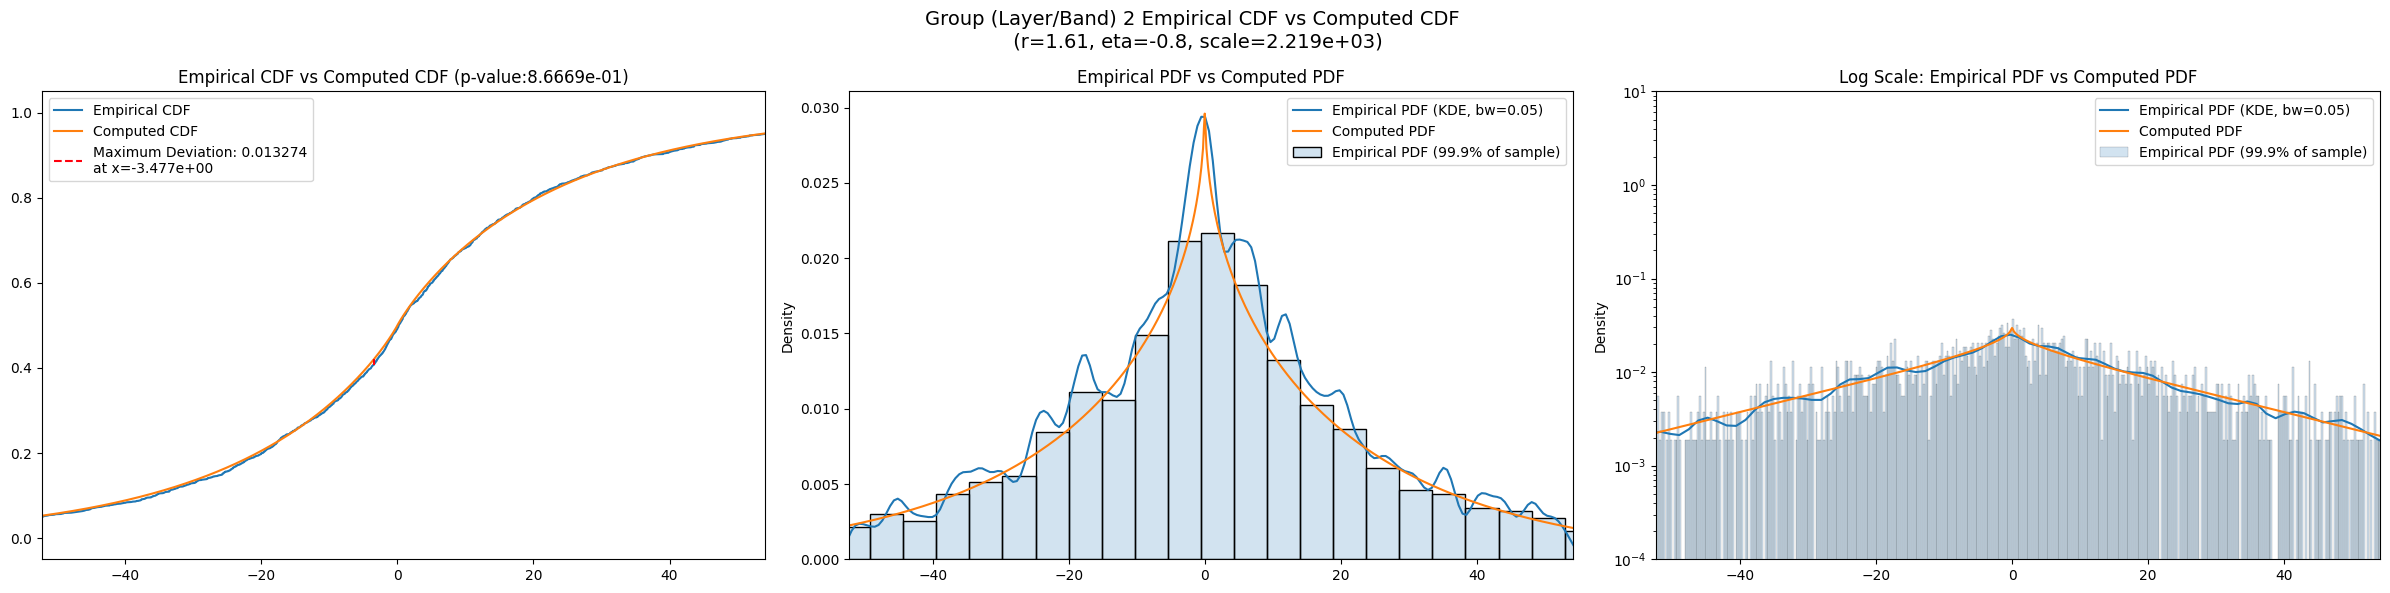

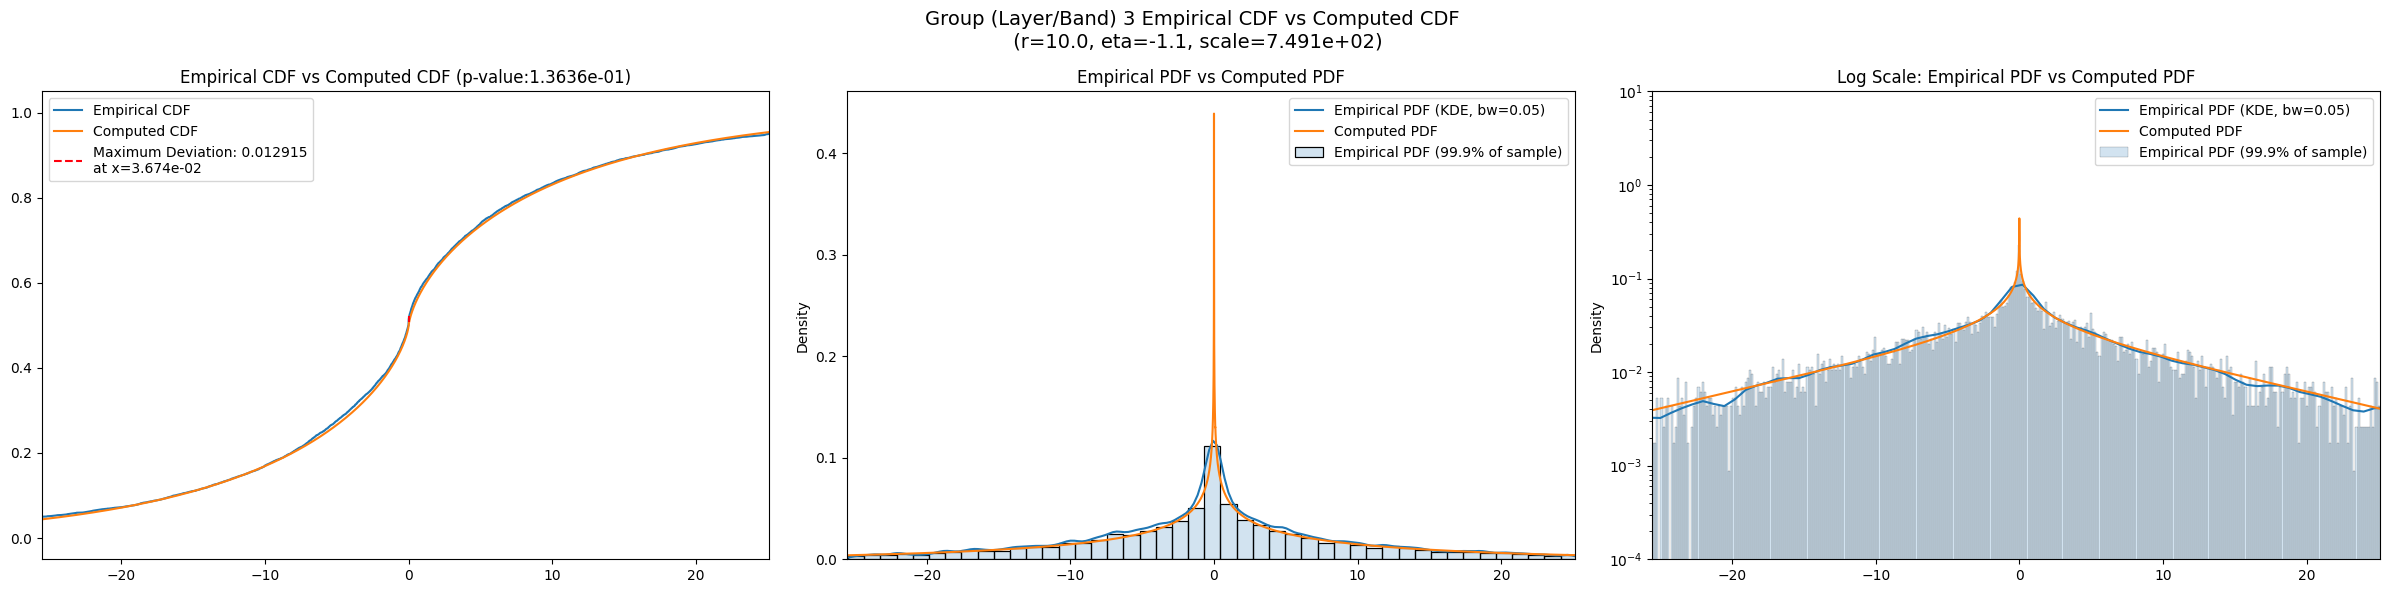

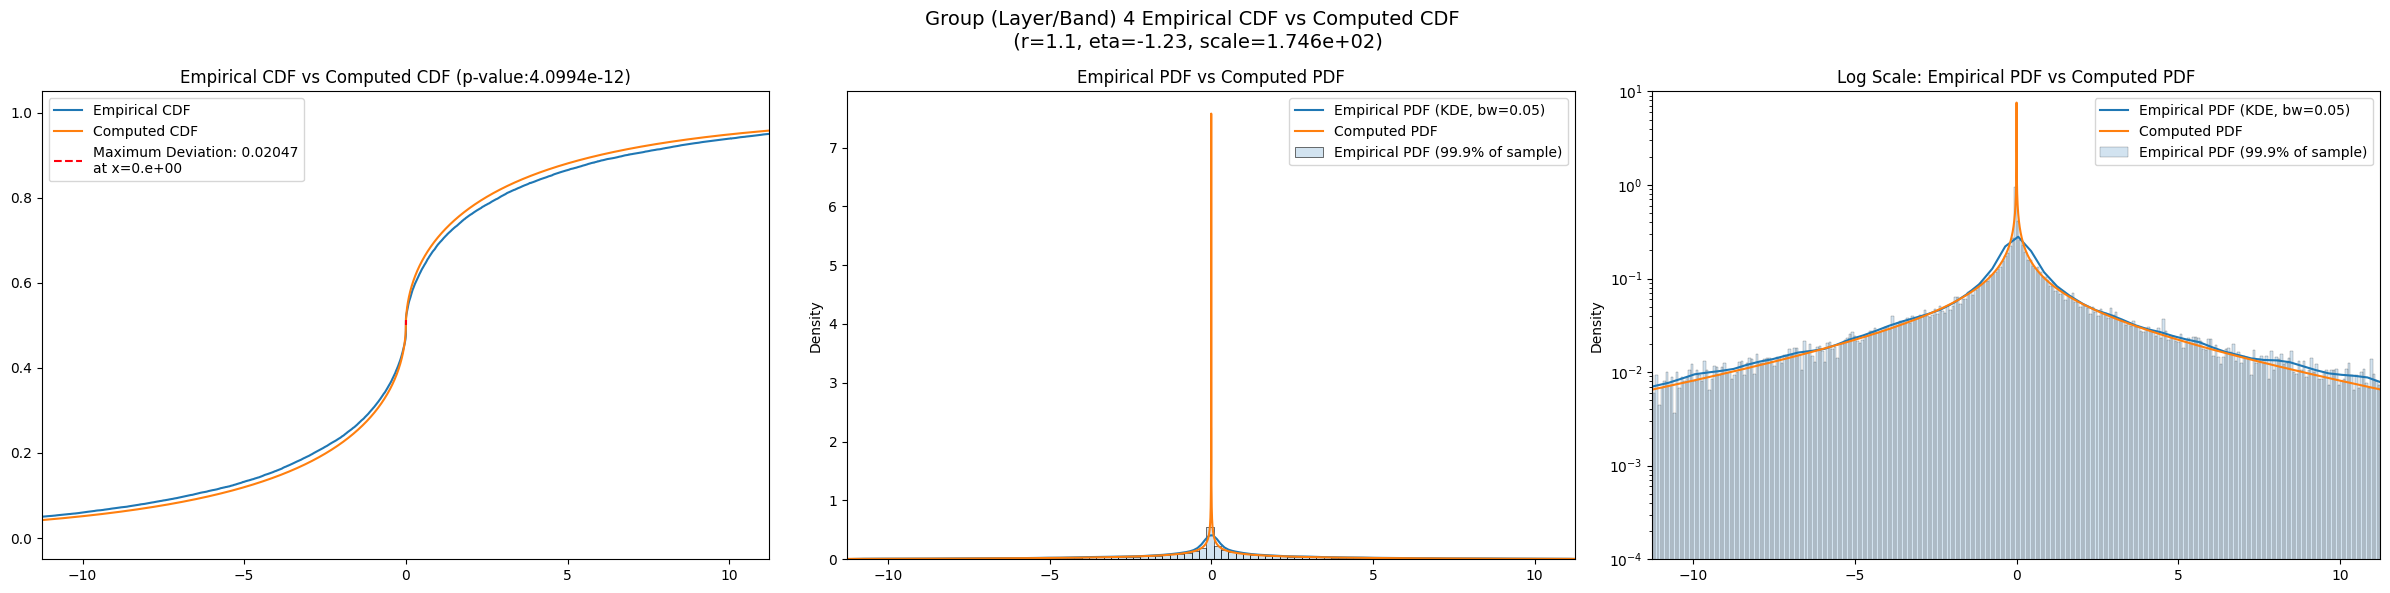

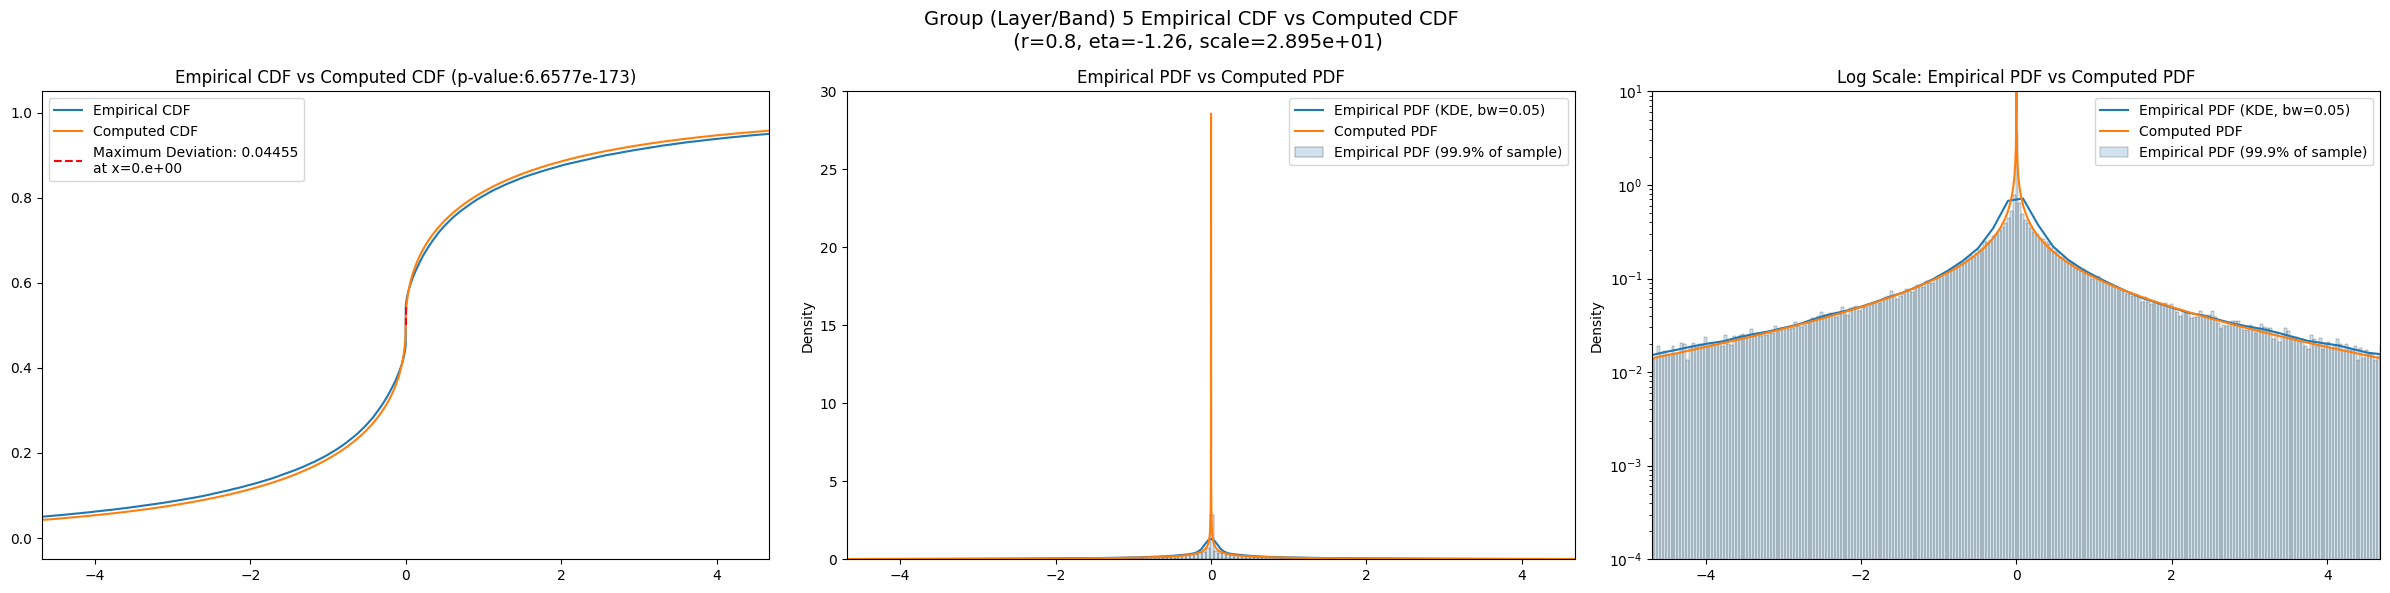

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                
2      1056.889000  930.928500  1189.896000   2.568110    1.749090   
3       231.587700  215.850390   247.845180   3.800917    3.201513   
4        48.523850   45.008670    52.177510   6.300665    5.255464   
5         9.365974    8.577611    10.193540   9.227902    7.612481   
6         1.842475    1.669544     2.028080  12.415792    9.957208   
7         0.408683    0.368238     0.452737  14.210211   10.879326   
8         0.140603    0.127459     0.154797  12.104240    9.034415   
9         0.072376    0.066349     0.079045   9.536445    6.531637   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.483325         2006.0             0.013333        1.6         -0.8   
3        4.483109         8024.0             0.012825       10.0         -1.1   
4        7.579384        32096.0             0.020470        1.3         -1.2   
5       12.297548       128384.0             0.044550        0.9         -1.3   
6       16.035275       513536.0             0.084600        1.1         -1.3   
7       19.988205      2054144.0             0.130230        0.3         -1.3   
8       17.255356      8216576.0             0.176500        0.7         -0.3   
9       16.300930     32866304.0             0.223060        0.1         -1.2   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       25.031400              0.040786          2.455050e-03   
3      ...        9.468070              0.059545          3.577280e-25   
4      ...        3.335650              0.080447         3.971170e-181   
5      ...        1.171520              0.087753          0.000000e+00   
6      ...        0.416392              0.096523          0.000000e+00   
7      ...        0.160716              0.130237          0.000000e+00   
8      ...        0.200972              0.176500          0.000000e+00   
9      ...        0.126888              0.223060          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          21.385500             0.018195         5.142000e-01  17.469800   
3           7.845660             0.038185         1.332880e-10   6.410180   
4           2.798200             0.057281         5.592210e-92   2.204670   
5           0.957935             0.067172         0.000000e+00   0.737691   
6           0.306129             0.086154         0.000000e+00   0.241091   
7           0.110722             0.130234         0.000000e+00   0.089454   
8           0.197911             0.176500         0.000000e+00   0.126889   
9           0.163404             0.223060         0.000000e+00   0.108716   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.023543   2.127860e-01          8.666931e-01  
3           0.042862   3.015130e-13          1.415277e-01  
4           0.060185  1.660930e-101          4.099360e-12  
5           0.068999   0.000000e+00         7.426926e-222  
6           0.087368   0.000000e+00          0.000000e+00  
7           0.130234   0.000000e+00          0.000000e+00  
8           0.176500   0.000000e+00          0.000000e+00  
9           0.223060   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.013333                 0.030238          0.013274   
3                 0.012825                 0.015140          0.012825   
4                 0.020470                 0.007575          0.020470   
5                 0.044550                 0.003789          0.044550   
6                 0.084600                 0.001895          0.084600   
7                 0.130230                 0.000947          0.130230   
8                 0.176500                 0.000474          0.176500   
9                 0.223060                 0.000237          0.223060   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040786             0.018195       0.023543  
3                  0.059545             0.038185       0.042862  
4                  0.080447             0.057281       0.060185  
5                  0.087753             0.067172       0.068999  
6                  0.096523             0.086154       0.087368  
7                  0.130237             0.130234       0.130234  
8                  0.176500             0.176500       0.176500  
9                  0.223060             0.223060       0.223060

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1056.889038          0.013274    1.61     -0.80  2.218582e+03   
3              204.831920          0.012825   10.00     -1.10  7.490835e+02   
4               44.008091          0.020470    1.10     -1.23  1.746343e+02   
5                8.600798          0.044550    0.80     -1.26  2.894678e+01   
6                1.842475          0.084600    1.10     -1.30  9.795379e+00   
7                0.408683          0.130230    0.30     -1.30  9.223405e-02   
8                0.140603          0.176500    0.70     -0.30  5.593899e-02   
9                0.072376          0.223060    0.10     -1.20  3.021948e-10   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     25.0  
4                     50.0  
5                    100.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()